In [127]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.stattools import durbin_watson
from statsmodels.compat import lzip
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model


input_file = Path(r"/Users/gelo/REPOS/finm-data-analysis-2024/data/ols_forecasting_inflation_data.xlsx")

# 2 Models of Volatility

In [128]:
SnP_df = pd.read_excel(input_file, sheet_name='s&p500',header=0,index_col=0)
SnP_df.head()

,SPY
Date,
1993-02-28,0.010669
1993-03-31,0.022400
1993-04-30,-0.025588
1993-05-31,0.026969
1993-06-30,0.003607


In [129]:
SnP_df['Expanding Window'] = SnP_df['SPY'] ** 2
SnP_df['Expanding Window'] = SnP_df['Expanding Window'].expanding().mean()
SnP_df['Expanding Window'] = SnP_df['Expanding Window']**(1/2)
SnP_df['Expanding Window']

Date
1993-02-28    0.010669
1993-03-31    0.017544
1993-04-30    0.020578
1993-05-31    0.022347
1993-06-30    0.020053
                ...   
2024-01-31    0.043974
2024-02-29    0.043998
2024-03-31    0.043972
2024-04-30    0.043963
2024-05-31    0.043955
Name: Expanding Window, Length: 376, dtype: float64

In [130]:
SnP_df['Rolling Window'] = SnP_df['SPY'].rolling(60).std()
SnP_df['Rolling Window']

Date
1993-02-28         NaN
1993-03-31         NaN
1993-04-30         NaN
1993-05-31         NaN
1993-06-30         NaN
                ...   
2024-01-31    0.052689
2024-02-29    0.052877
2024-03-31    0.052936
2024-04-30    0.053250
2024-05-31    0.052445
Name: Rolling Window, Length: 376, dtype: float64

In [131]:
theta = 0.97
init_vol = (0.15*(1/((12)**(1/2))))**2
SnP_df['IGARCH'] = pd.NA
SnP_df.iloc[0,3] = init_vol
for t in range(1, len(SnP_df)):
    a = theta*SnP_df.iloc[t-1,3]
    b = (1-theta)*(SnP_df.iloc[t-1,0]**2)
    SnP_df.iloc[t,3] =  a + b
SnP_df['IGARCH'] = SnP_df['IGARCH'] **(1/2)
SnP_df['IGARCH']

Date
1993-02-28    0.043301
1993-03-31    0.042687
1993-04-30     0.04222
1993-05-31    0.041818
1993-06-30     0.04145
                ...   
2024-01-31    0.051552
2024-02-29    0.050848
2024-03-31    0.050889
2024-04-30    0.050439
2024-05-31    0.050165
Name: IGARCH, Length: 376, dtype: object

In [132]:
model = arch_model(SnP_df['SPY'], vol='GARCH', p=1, q=1)
garch_fit = model.fit()
garch_fit.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 136905287.20325646
Iteration:      2,   Func. Count:     17,   Neg. LLF: 1044759.9548106429
Iteration:      3,   Func. Count:     24,   Neg. LLF: -669.8186331265372
Iteration:      4,   Func. Count:     30,   Neg. LLF: 9212.798170910562
Iteration:      5,   Func. Count:     40,   Neg. LLF: 537.2601220639692
Iteration:      6,   Func. Count:     49,   Neg. LLF: -669.1535312645367
Iteration:      7,   Func. Count:     55,   Neg. LLF: -678.3262292913266
Iteration:      8,   Func. Count:     61,   Neg. LLF: -667.851868240446
Iteration:      9,   Func. Count:     67,   Neg. LLF: -679.1765228203155
Iteration:     10,   Func. Count:     73,   Neg. LLF: -679.1927990554591
Iteration:     11,   Func. Count:     79,   Neg. LLF: -679.2012046619566
Iteration:     12,   Func. Count:     84,   Neg. LLF: -679.2012683140181
Iteration:     13,   Func. Count:     88,   Neg. LLF: -679.2012683139549
Optimization terminated successfully    (Exit mode 0)


/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00185. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                    SPY   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                679.201
Distribution:                  Normal   AIC:                          -1350.40
Method:            Maximum Likelihood   BIC:                          -1334.68
                                        No. Observations:                  376
Date:                Wed, Aug 14 2024   Df Residuals:                      375
Time:                        14:55:04   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0101  1.792e-03      5.656  1.554e-08 [6.621e-03,1.364e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.7404e-05  5.221e-05      1.865  6.212e-02 [-4.934e-06,1.997e-04]
alpha[1]       0.1940  6.136e-02      3.162  1.569e-03    [7.373e-02,  0.314]
beta[1]        0.7669  7.295e-02     10.512  7.636e-26      [  0.624,  0.910]
=============================================================================

Covariance estimator: robust
"""

In [135]:
SnP_df['GARCH'] = garch_fit.conditional_volatility.rename('GARCH')
SnP_df

,SPY,Expanding Window,Rolling Window,IGARCH,GARCH
Date,,,,,
1993-02-28,0.010669,0.010669,NaN,0.043301,0.026892
1993-03-31,0.022400,0.017544,NaN,0.042687,0.025535
1993-04-30,-0.025588,0.020578,NaN,0.04222,0.025032
1993-05-31,0.026969,0.022347,NaN,0.041818,0.028730
1993-06-30,0.003607,0.020053,NaN,0.04145,0.028025
...,...,...,...,...,...
2024-01-31,0.015926,0.043974,0.052689,0.051552,0.049623
2024-02-29,0.052187,0.043998,0.052877,0.050848,0.044635
2024-03-31,0.032702,0.043972,0.052936,0.050889,0.044365


(10285.0, 19874.0)

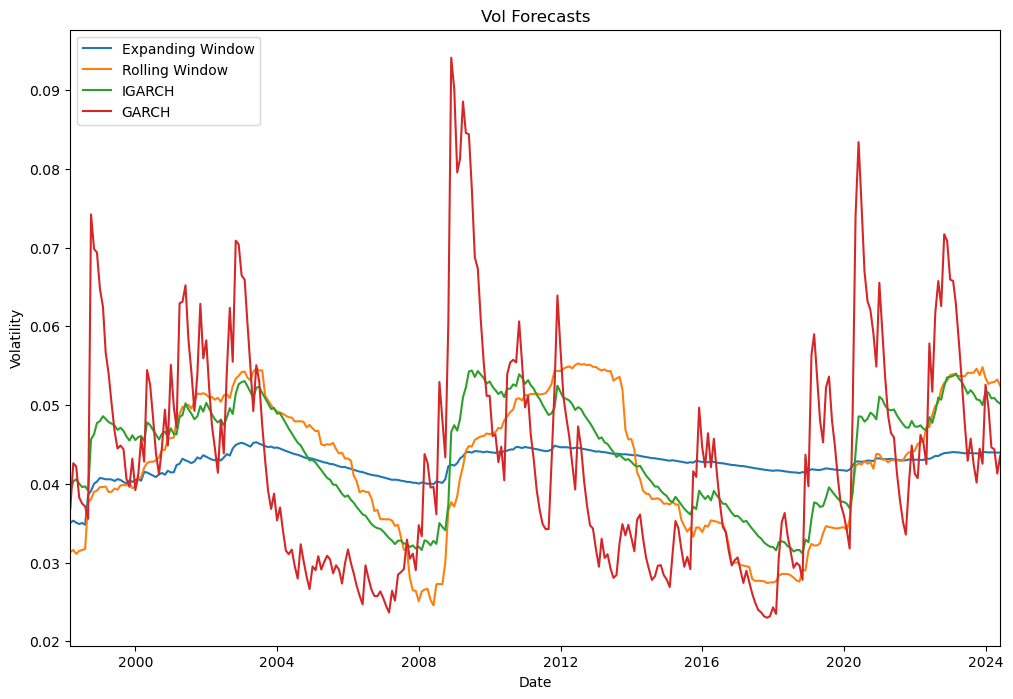

In [136]:
plt.figure(figsize=(12,8))
plt.plot(SnP_df.index[60:], SnP_df['Expanding Window'][60:], label = 'Expanding Window')
plt.plot(SnP_df.index[60:], SnP_df['Rolling Window'][60:], label = 'Rolling Window')
plt.plot(SnP_df.index[60:], SnP_df['IGARCH'][60:], label = 'IGARCH')
plt.plot(SnP_df.index[60:], SnP_df['GARCH'][60:], label = 'GARCH')
plt.title("Vol Forecasts")
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend(loc = 'upper left')
plt.xlim(left=SnP_df.index[60], right=SnP_df.index[-1])

In [138]:
dates = SnP_df.loc[['2008-10-31', '2020-04-30', '2024-05-31']]
dates

,SPY,Expanding Window,Rolling Window,IGARCH,GARCH
Date,,,,,
2008-10-31,-0.165187,0.042229,0.036584,0.037334,0.060410
2020-04-30,0.126983,0.042824,0.042294,0.043947,0.074080
2024-05-31,0.041097,0.043955,0.052445,0.050165,0.043579
